In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
!pip install torchaudio
!pip install PyDrive
!pip install soundfile

     |████████████████████████████████| 3.2MB 6.6MB/s 


In [3]:
! git clone https://github.com/facebookresearch/CPC_audio.git

Cloning into 'CPC_audio'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 84 (delta 13), reused 75 (delta 6), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [4]:
%cd /content/CPC_audio
!python setup.py develop

/content/CPC_audio
Compiling cpc/eval/ABX/dtw.pyx because it changed.
[1/1] Cythonizing cpc/eval/ABX/dtw.pyx
running develop
running egg_info
creating CPC_audio.egg-info
writing CPC_audio.egg-info/PKG-INFO
writing dependency_links to CPC_audio.egg-info/dependency_links.txt
writing top-level names to CPC_audio.egg-info/top_level.txt
writing manifest file 'CPC_audio.egg-info/SOURCES.txt'
writing manifest file 'CPC_audio.egg-info/SOURCES.txt'
running build_ext
building 'cpc.eval.ABX.dtw' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/cpc
creating build/temp.linux-x86_64-3.6/cpc/eval
creating build/temp.linux-x86_64-3.6/cpc/eval/ABX
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I/usr/include/python3.6m -c cpc/eval/ABX/dtw.c -o build/temp.linux-x86_64-3.6/cpc/eval/ABX/

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import torch
import torchaudio

# Part 1 : contrastive predictive coding

Contrastive Predictive Coding (CPC) is a method of unsupervised training for speech models. The idea behind it is pretty simple:


1.   The raw audio wave is passed through a convolutional network: the ```encoder```
2.   Then, the encoder's output is given to a recurrent network the ```context```
3. A third party network, the ```prediction_network``` will try to predict the  future embeddings of the encoder using the output of the context network.

In order to avoid a collapse to trivial solutions, the prediction_network doesn't try to reconstruct the future features. Instead, using the context output $c_t$ at time $t$ it is trained to discriminate the real  encoder representatioin $g_{t+k}$ at time $t+k$ from several other features $(g_n)_n$ taken elsewhere in the batch. Thus the loss becomes:

\\[ \mathcal{L}_c = - \frac{1}{K} \sum_{k=1}^K \text{Cross_entropy}(\phi_k(c_t), g_{t+k}) \\]

Or:

\\[ \mathcal{L}_c = - \frac{1}{K} \sum_{k=1}^K \log \frac{ \exp\left(\phi_k(c_t)^\top g_{t+k}\right) }{  \sum_{\mathbf{n}\in\mathcal{N}_t} \exp\left(\phi_k(c_t)^\top g_n\right)} \\]

Where:


*   $\phi_k$ is the prediction network for the kth timestep
*   $\mathcal{N}_t$ is the set of all negative examples sampled for timestep $t$




## Exercice 1 : Building the model

In this exercise, we will build and train a small CPC model using the repository CPC_audio.

The code below loads a context and an encoder newtorks.

In [7]:
%cd /content/CPC_audio
from cpc.model import CPCEncoder, CPCAR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DIM_ENCODER=256
DIM_CONTEXT=256
KEEP_HIDDEN_VECTOR=False
N_LEVELS_CONTEXT=1
CONTEXT_RNN="LSTM"
N_PREDICTIONS=12
LEARNING_RATE=2e-4
N_NEGATIVE_SAMPLE =128

/content/CPC_audio


In [8]:
encoder = CPCEncoder(DIM_ENCODER).to(device)
context = CPCAR(DIM_ENCODER, DIM_CONTEXT, KEEP_HIDDEN_VECTOR, 1, mode=CONTEXT_RNN).to(device)

In [9]:
# Several functions that will be necessary to load the data later
from cpc.dataset import findAllSeqs, AudioBatchData, parseSeqLabels
SIZE_WINDOW = 20480
BATCH_SIZE=8
def load_dataset(path_dataset, file_extension='.wav', phone_label_dict=None):
  data_list, speakers = findAllSeqs(path_dataset, extension=file_extension)
  dataset = AudioBatchData(path_dataset, SIZE_WINDOW, data_list, phone_label_dict, len(speakers))
  return dataset

Now build a new class, ```CPCModel``` which will

In [10]:
class CPCModel(torch.nn.Module):

    def __init__(self,
                 encoder,
                 AR):

        super(CPCModel, self).__init__()
        self.gEncoder = encoder
        self.gAR = AR

    def forward(self, batch_data):
        

        encoder_output = self.gEncoder(batch_data)
        #print(encoder_output.shape)
        # The output of the encoder data does not have the good format 
        # indeed it is Batch_size x Hidden_size x temp size
        # while the context requires Batch_size  x temp size x Hidden_size
        # thus you need to permute
        context_input = encoder_output.permute(0, 2, 1)

        context_output = self.gAR(context_input)
        #print(context_output.shape)
        return context_output, encoder_output

Let's test your code !


In [14]:
ls

build/              CONTRIBUTING.md  CPC_audio.egg-info/  hubconf.py  README.md
CODE_OF_CONDUCT.md  cpc/             environment.yml      LICENSE     setup.py


In [11]:
audio = torchaudio.load("/content/drive/My Drive/Data-ASR/Prepared DATA/train/200626-225149_gaa_980_elicit/200626-225149_gaa_980_elicit_0.wav")[0]
audio = audio.view(1, 1, -1)
cpc_model = CPCModel(encoder, context).to(device)
context_output, encoder_output = cpc_model(audio.to(device))

## Exercise 2 : CPC loss

We will define a class ```CPCCriterion``` which will hold the prediction networks $\phi_k$ defined above and perform the classification loss $\mathcal{L}_c$.

a) In this exercise, the $\phi_k$ will be a linear transform, ie:

\\[ \phi_k(c_t) = \mathbf{A}_k c_t\\]

Using the class [torch.nn.Linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear), define the transformations $\phi_k$ in the code below and complete the function ```get_prediction_k``` which computes $\phi_k(c_t)$ for a given batch of vectors $c_t$.

b) Using both ```get_prediction_k```  and ```sample_negatives``` defined below, write the forward function which will take as input two batches of features $c_t$ and $g_t$ and outputs the classification loss $\mathcal{L}_c$ and the average acuracy for all predictions. 

In [12]:
# Exercice 2: write the CPC loss
# a) Write the negative sampling (with some help)
# ERRATUM: it's really hard, the sampling will be provided

class CPCCriterion(torch.nn.Module):

  def __init__(self,
               K,
               dim_context,
               dim_encoder,
               n_negative):
    super(CPCCriterion, self).__init__()
    self.K_ = K
    self.dim_context = dim_context
    self.dim_encoder = dim_encoder
    self.n_negative = n_negative

    self.predictors = torch.nn.ModuleList() 
    for k in range(self.K_):
      # TO COMPLETE !
      
      # A affine transformation in pytorch is equivalent to a nn.Linear layer
      # To get a linear transformation you must set bias=False
      # input dimension of the layer = dimension of the encoder
      # output dimension of the layer = dimension of the context
      self.predictors.append(torch.nn.Linear(dim_context, dim_encoder, bias=False))

  def get_prediction_k(self, context_data):

    #TO COMPLETE !
    output = [] 
    # For each time step k
    for k in range(self.K_):

      # We need to compute phi_k = A_k * c_t
      phi_k = self.predictors[k](context_data)
      output.append(phi_k)

    return output


  def sample_negatives(self, encoded_data):
    r"""
    Sample some negative examples in the given encoded data.
    Input:
    - encoded_data size: B x T x H
    Returns
    - outputs of size B x (n_negative + 1) x (T - K_) x H
      outputs[:, 0, :, :] contains the positive example
      outputs[:, 1:, :, :] contains negative example sampled in the batch
    - labels, long tensor of size B x (T - K_)
      Since the positive example is always at coordinates 0 for all sequences 
      in the batch and all timestep in the sequence, labels is just a tensor
      full of zeros !
    """
    batch_size, time_size, dim_encoded = encoded_data.size()
    window_size = time_size - self.K_
    outputs = []

    neg_ext = encoded_data.contiguous().view(-1, dim_encoded)
    n_elem_sampled = self.n_negative * window_size * batch_size
    # Draw nNegativeExt * batchSize negative samples anywhere in the batch
    batch_idx = torch.randint(low=0, high=batch_size,
                              size=(n_elem_sampled, ),
                              device=encoded_data.device)

    seq_idx = torch.randint(low=1, high=time_size,
                            size=(n_elem_sampled, ),
                            device=encoded_data.device)

    base_idx = torch.arange(0, window_size, device=encoded_data.device)
    base_idx = base_idx.view(1, 1, window_size)
    base_idx = base_idx.expand(1, self.n_negative, window_size)
    base_idx = base_idx.expand(batch_size, self.n_negative, window_size)
    seq_idx += base_idx.contiguous().view(-1)
    seq_idx = torch.remainder(seq_idx, time_size)

    ext_idx = seq_idx + batch_idx * time_size
    neg_ext = neg_ext[ext_idx].view(batch_size, self.n_negative,
                                    window_size, dim_encoded)
    label_loss = torch.zeros((batch_size, window_size),
                              dtype=torch.long,
                              device=encoded_data.device)

    for k in range(1, self.K_ + 1):

      # Positive samples
      if k < self.K_:
          pos_seq = encoded_data[:, k:-(self.K_-k)]
      else:
          pos_seq = encoded_data[:, k:]

      pos_seq = pos_seq.view(batch_size, 1, pos_seq.size(1), dim_encoded)
      full_seq = torch.cat((pos_seq, neg_ext), dim=1)
      outputs.append(full_seq)

    return outputs, label_loss

  def forward(self, encoded_data, context_data):

    # TO COMPLETE:
    # Perform the full cpc criterion
    # Returns 2 values:
    # - the average classification loss avg_loss
    # - the average classification acuracy avg_acc

    # Reminder : The permuation !
    encoded_data = encoded_data.permute(0, 2, 1)

    # First we need to sample the negative examples
    negative_samples, labels = self.sample_negatives(encoded_data)

    # Then we must compute phi_k
    phi_k = self.get_prediction_k(context_data)

    # Finally we must get the dot product between phi_k and negative_samples 
    # for each k

    #The total loss is the average of all losses
    avg_loss = 0

    # Average acuracy
    avg_acc = 0

    for k in range(self.K_):
      B, N_sampled, S_small, H = negative_samples[k].size() 
      B, S, H = phi_k[k].size()

      # As told before S = S_small + K. For segments too far in the sequence
      # there are no positive exmples anyway, so we must shorten phi_k
      phi = phi_k[k][:, :S_small]

      # Now the dot product
      # You have several ways to do that, let's do the simple but non optimal 
      # one
      # pytorch has a matrix product function https://pytorch.org/docs/stable/torch.html#torch.bmm
      # But it takes only 3D tensors of the same batch size !
      # To begin negative_samples is a 4D tensor ! 
      # We want to compute the dot product for each features, of each sequence
      # of the batch. Thus we are trying to compute a dot product for all
      # B* N_sampled * S_small 1D vector of negative_samples[k]
      # Or, a 1D tensor of size H is also a matrix of size 1 x H
      # Then, we must view it as a 3D tensor of size (B* N_sampled * S_small, 1, H)
      negative_sample_k  =  negative_samples[k].view(B* N_sampled* S_small, 1, H)

      # But now phi and negative_sample_k no longer have the same batch size !
      # No worries, we can expand phi so that each sequence of the batch
      # is repeated N_sampled times
      phi = phi.view(B, 1,S_small, H).expand(B, N_sampled, S_small, H)

      # And now we can view it as a 3D tensor 
      phi  = phi.contiguous().view(B * N_sampled * S_small, H, 1)

      # We can finally get the dot product !
      scores = torch.bmm(negative_sample_k, phi)

      # Dot_product has a size (B * N_sampled * S_small , 1, 1)
      # Let's reorder it a bit
      scores = scores.reshape(B, N_sampled, S_small)

      # For each elements of the sequence, and each elements sampled, it gives 
      # a floating score stating the likelihood of this element being the 
      # true one.
      # Now the classification loss, we need to use the Cross Entropy loss
      # https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html

      # For each time-step of each sequence of the batch 
      # we have N_sampled possible predictions. 
      # Looking at the documentation of torch.nn.CrossEntropyLoss
      # we can see that this loss expect a tensor of size M x C where 
      # - M is the number of elements with a classification score
      # - C is the number of possible classes
      # There are N_sampled candidates for each predictions so
      # C = N_sampled 
      # Each timestep of each sequence of the batch has a prediction so
      # M = B * S_small
      # Thus we need an input vector of size B * S_small, N_sampled
      # To begin, we need to permute the axis
      scores = scores.permute(0, 2, 1) # Now it has size B , S_small, N_sampled

      # Then we can cast it into a 2D tensor
      scores = scores.reshape(B * S_small, N_sampled)

      # Same thing for the labels 
      labels = labels.reshape(B * S_small)

      # Finally we can get the classification loss
      loss_criterion = torch.nn.CrossEntropyLoss()
      loss_k = loss_criterion(scores, labels)
      avg_loss+= loss_k

      # And for the acuracy
      # The prediction for each elements is the sample with the highest score
      # Thus the tensors of all predictions is the tensors of the index of the 
      # maximal score for each time-step of each sequence of the batch
      predictions = torch.argmax(scores, 1)
      acc_k  = (labels == predictions).sum() / (B * S_small)
      avg_acc += acc_k

    # Normalization
    avg_loss = avg_loss / self.K_
    avg_acc = avg_acc / self.K_
      
    return avg_loss , avg_acc

Don't forget to test !

In [13]:
audio = torchaudio.load("/content/drive/My Drive/Data-ASR/Prepared DATA/train/200626-225149_gaa_980_elicit/200626-225149_gaa_980_elicit_0.wav")[0]
audio = audio.view(1, 1, -1)
cpc_criterion = CPCCriterion(N_PREDICTIONS, DIM_CONTEXT, 
                             DIM_ENCODER, N_NEGATIVE_SAMPLE).to(device)
context_output, encoder_output = cpc_model(audio.to(device))
loss, avg = cpc_criterion(encoder_output,context_output)

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


## Exercise 3: Full training loop !

You have the model, you have the criterion. All you need now are a data loader and an optimizer to run your training loop.

We will use an Adam optimizer:

In [14]:
parameters = list(cpc_criterion.parameters()) + list(cpc_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

And as far as the data loader is concerned, we will rely on the data loader provided by the CPC_audio library.

In [15]:
dataset_train = load_dataset('/content/drive/My Drive/Data-ASR/Prepared DATA/train')
dataset_val = load_dataset('/content/drive/My Drive/Data-ASR/Prepared DATA/validation')
data_loader_train = dataset_train.getDataLoader(BATCH_SIZE, "speaker", True)
data_loader_val = dataset_train.getDataLoader(BATCH_SIZE, "sequence", False)

21it [00:07,  2.72it/s]


Saved cache file at /content/drive/My Drive/Data-ASR/Prepared DATA/train/_seqs_cache.txt
Checking length...


849it [00:00, 214930.23it/s]


Done, elapsed: 28.703 seconds
Scanned 849 sequences in 28.70 seconds
1 chunks computed
Joining pool


0it [00:00, ?it/s]

Joined process, elapsed=2.216 secs


8it [00:04,  2.00it/s]


Saved cache file at /content/drive/My Drive/Data-ASR/Prepared DATA/validation/_seqs_cache.txt
Checking length...


378it [00:00, 94444.92it/s]


Done, elapsed: 12.689 seconds
Scanned 378 sequences in 12.69 seconds
1 chunks computed
Joining pool
Joined process, elapsed=1.036 secs


Now that everything is ready, complete and test the ```train_step``` function below which trains the model for one epoch.

In [16]:
def train_step(data_loader,
               cpc_model,
               cpc_criterion,
               optimizer):
  
  avg_loss = 0
  avg_acc = 0
  n_items = 0

  for step, data in enumerate(data_loader):
    x,y = data
    bs = len(x)
    optimizer.zero_grad()
    context_output, encoder_output = cpc_model(x.to(device))
    loss , acc = cpc_criterion(encoder_output, context_output)
    loss.backward()
    n_items+=bs
    avg_loss+=loss.item()*bs
    avg_acc +=acc.item()*bs
  
  avg_loss/=n_items
  avg_acc/=n_items
  return avg_loss, avg_acc

## Exercise 4 : Validation loop

Now complete the validation loop.

In [17]:
def validation_step(data_loader,
                    cpc_model,
                    cpc_criterion):
  
  avg_loss = 0
  avg_acc = 0
  n_items = 0

  for step, data in enumerate(data_loader):
    x,y = data
    bs = len(x)
    context_output, encoder_output = cpc_model(x.to(device))
    loss , acc = cpc_criterion(encoder_output, context_output)
    n_items+=bs
    avg_loss+=loss.item()*bs
    avg_acc+=acc.item()*bs
  
  avg_loss/=n_items
  avg_acc/=n_items
  return avg_loss, avg_acc

## Exercise 5: Run everything

In [18]:
def run(train_loader,
        val_loader,
        cpc_model,
        cpc_criterion,
        optimizer,
        n_epochs):
  
  for epoch in range(n_epochs):

    
    print(f"Running epoch {epoch+1} / {n_epochs}")
    avg_loss_train, avg_acc_train = train_step(train_loader, cpc_model, cpc_criterion, optimizer)
    print("----------------------")
    print(f"Training dataset")
    print(f"- average loss : {avg_loss_train}")
    print(f"- average acuracy : {avg_acc_train}")
    print("----------------------")
    with torch.no_grad():
      cpc_model.eval()
      cpc_criterion.eval()
      avg_loss_val, avg_acc_val = validation_step(val_loader, cpc_model, cpc_criterion)
      print(f"Validation dataset")
      print(f"- average loss : {avg_loss_val}")
      print(f"- average acuracy : {avg_acc_val}")
      print("----------------------")
      print()
      cpc_model.train()
      cpc_criterion.train()

In [19]:
run(data_loader_train, data_loader_val, cpc_model,cpc_criterion,optimizer,2)

Running epoch 1 / 2
----------------------
Training dataset
- average loss : 4.876497977247862
- average acuracy : 0.0
----------------------
Validation dataset
- average loss : 4.876419560560185
- average acuracy : 0.0
----------------------

Running epoch 2 / 2
----------------------
Training dataset
- average loss : 4.876546626521791
- average acuracy : 0.0
----------------------
Validation dataset
- average loss : 4.876449483948704
- average acuracy : 0.0
----------------------



Once everything is donw, clear the memory.

In [20]:
del dataset_train
del dataset_val
del cpc_model
del context
del encoder

# Part 2 : Fine tuning

## Exercice 1 : Phone separability with aligned phonemes.

One option to evaluate the quality of the features trained with CPC can be to check if they can be used to recognize phonemes. 
To do so, we can fine-tune a pre-trained model using a limited amount of labelled speech data.
We are going to start with a simple evaluation setting where we have the phone labels for each timestep corresponding to a CPC feature.

We will work with a model already pre-trained on English data. As far as the fine-tuning dataset is concerned, we will use a 1h subset of [librispeech-100](http://www.openslr.org/12/). 

In [21]:
!mkdir checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_args.json -P checkpoint_data
!ls checkpoint_data

--2020-07-05 09:29:56--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113599715 (108M) [application/octet-stream]
Saving to: ‘checkpoint_data/checkpoint_30.pt’

checkpoint_30.pt    100%[===================>] 108.34M  5.04MB/s    in 24s     

2020-07-05 09:30:21 (4.50 MB/s) - ‘checkpoint_data/checkpoint_30.pt’ saved [113599715/113599715]

--2020-07-05 09:30:23--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request 

In [1]:
!ls

sample_data


In [22]:
%cd /content/CPC_audio
from cpc.dataset import parseSeqLabels
from cpc.feature_loader import loadModel

checkpoint_path = 'checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()
label_dict, N_PHONES = parseSeqLabels('/content/drive/My Drive/Data-ASR/Prepared DATA/all_sessions1.txt')
dataset_train = load_dataset('/content/drive/My Drive/Data-ASR/Prepared DATA/train', file_extension='.wav', phone_label_dict=label_dict)
dataset_val = load_dataset('/content/drive/My Drive/Data-ASR/Prepared DATA/validation', file_extension='.wav', phone_label_dict=label_dict)
data_loader_train = dataset_train.getDataLoader(BATCH_SIZE, "speaker", True)
data_loader_val = dataset_val.getDataLoader(BATCH_SIZE, "sequence", False)

/content/CPC_audio
Loading checkpoint checkpoint_data/checkpoint_30.pt
Loading the state dict at checkpoint_data/checkpoint_30.pt


21it [00:00, 554.07it/s]

Saved cache file at /content/drive/My Drive/Data-ASR/Prepared DATA/train/_seqs_cache.txt


Checking length...


849it [00:00, 131299.14it/s]


Done, elapsed: 0.954 seconds
Scanned 849 sequences in 0.96 seconds
1 chunks computed
Joining pool


3it [00:00, 25.65it/s]

Joined process, elapsed=2.401 secs


8it [00:00, 27.38it/s]


Saved cache file at /content/drive/My Drive/Data-ASR/Prepared DATA/validation/_seqs_cache.txt
Checking length...


378it [00:00, 587637.85it/s]


Done, elapsed: 0.676 seconds
Scanned 378 sequences in 0.68 seconds
1 chunks computed
Joining pool
Joined process, elapsed=1.102 secs


Then we will use a simple linear classifier to recognize the phonemes from the features produced by ```cpc_model```. 

### a) Build the phone classifier 

Design a class of linear classifiers, ```PhoneClassifier``` that will take as input a batch of sequences of CPC features and output a score vector for each phoneme

In [23]:
class PhoneClassifier(torch.nn.Module):

  def __init__(self,
               input_dim : int,
               n_phones : int):
    super(PhoneClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, n_phones)
    

  def forward(self, x):
    return self.linear(x)

Our phone classifier will then be:

In [24]:
phone_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_PHONES).to(device)

### b - What would be the correct loss criterion for this task ?



In [25]:
loss_criterion = torch.nn.CrossEntropyLoss()

To perform the fine-tuning, we will also need an optimization function.

We will use an [Adam optimizer ](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [26]:
parameters = list(phone_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

You might also want to perform this training while freezing the weights of the ```cpc_model```. Indeed, if the pre-training was good enough, then ```cpc_model``` phonemes representation should be linearly separable. In this case the optimizer should be defined like this:

In [27]:
optimizer_frozen = torch.optim.Adam(list(phone_classifier.parameters()), lr=LEARNING_RATE)

### c- Now let's build a training loop. 
Complete the function ```train_one_epoch``` below.



In [28]:
def train_one_epoch(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader, 
                    optimizer):

  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):
    # Each batch is represented by a Tuple of vectors:
    # sequence of size : N x 1 x T
    # label of size : N x T
    # 
    # With :
    # - N number of sequence in the batch
    # - T size of each sequence
    sequence, label = full_data
    
    

    bs = len(sequence)
    seq_len = label.size(1)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(sequence.to(device),label.to(device))

    scores = phone_classifier(context_out)

    scores = scores.permute(0,2,1)
    loss = loss_criterion(scores,label.to(device))
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
    correct_labels = scores.argmax(1)
    avg_accuracy += ((label==correct_labels.cpu()).float()).mean(1).sum().item()
  avg_loss/=n_items
  avg_accuracy/=n_items
  return avg_loss, avg_accuracy
    

Don't forget to test it !

In [29]:
avg_loss, avg_accuracy = train_one_epoch(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer_frozen)

In [30]:
avg_loss, avg_accuracy

(3.8899461882455006, 0.04868861607142857)

### d- Build the validation loop

In [31]:
def validation_step(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader):
  
  cpc_model.eval()
  phone_classifier.eval()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):
      # Each batch is represented by a Tuple of vectors:
      # sequence of size : N x 1 x T
      # label of size : N x T
      # 
      # With :
      # - N number of sequence in the batch
      # - T size of each sequence
      sequence, label = full_data
      bs = len(sequence)
      seq_len = label.size(1)
      context_out, enc_out, _ = cpc_model(sequence.to(device),label.to(device))
      scores = phone_classifier(context_out)
      scores = scores.permute(0,2,1)
      loss = loss_criterion(scores,label.to(device))
      avg_loss+=loss.item()*bs
      n_items+=bs
      correct_labels = scores.argmax(1)
      avg_accuracy += ((label==correct_labels.cpu()).float()).mean(1).sum().item()
  avg_loss/=n_items
  avg_accuracy/=n_items
  return avg_loss, avg_accuracy

### e- Run everything

Test this functiion with both ```optimizer``` and ```optimizer_frozen```.

In [33]:
def run(cpc_model, 
        phone_classifier, 
        loss_criterion, 
        data_loader_train, 
        data_loader_val, 
        optimizer,
        n_epoch):
    train_loss = []
    validation_loss = []
    for epoch in range(n_epoch):

      print(f"Running epoch {epoch + 1} / {n_epoch}")
      loss_train, acc_train = train_one_epoch(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer)
      train_loss.append(loss_train)
      print("-------------------")
      print(f"Training dataset :")
      print(f"Average loss : {loss_train}. Average accuracy {acc_train}")

      print("-------------------")
      print("Validation dataset")
      loss_val, acc_val = validation_step(cpc_model, phone_classifier, loss_criterion, data_loader_val)
      validation_loss.append(loss_val)
      print(f"Average loss : {loss_val}. Average accuracy {acc_val}")
      print("-------------------")
      print()
    return train_loss, validation_loss

In [34]:
train_loss, validation_loss = run(cpc_model,phone_classifier,loss_criterion,data_loader_train,data_loader_val,optimizer_frozen,n_epoch=30)

Running epoch 1 / 30
-------------------
Training dataset :
Average loss : 3.7681499889918735. Average accuracy 0.06696428571428571
-------------------
Validation dataset
Average loss : 3.7258415487077503. Average accuracy 0.0849609375
-------------------

Running epoch 2 / 30
-------------------
Training dataset :
Average loss : 3.6620839209783647. Average accuracy 0.08170572916666667
-------------------
Validation dataset
Average loss : 3.632444381713867. Average accuracy 0.09212239583333333
-------------------

Running epoch 3 / 30
-------------------
Training dataset :
Average loss : 3.5741959526425315. Average accuracy 0.0859375
-------------------
Validation dataset
Average loss : 3.556492222679986. Average accuracy 0.09418402777777778
-------------------

Running epoch 4 / 30
-------------------
Training dataset :
Average loss : 3.494688113530477. Average accuracy 0.08942522321428571
-------------------
Validation dataset
Average loss : 3.487292077806261. Average accuracy 0.0935

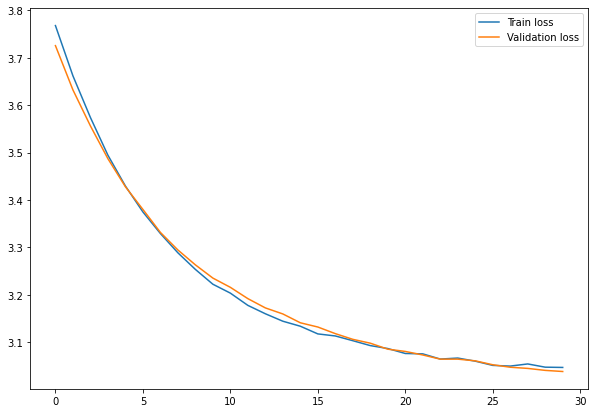

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot(train_loss, label='Train loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend()
plt.show()

## Exercise 2 : Phone separability without alignment (PER)

Aligned data are very practical, but un real life they are rarely available. That's why in this excercise we will consider a fine-tuning with non-aligned phonemes.

The model, the optimizer and the phone classifier will stay the same. However, we will replace our phone criterion with a [CTC loss](https://pytorch.org/docs/master/generated/torch.nn.CTCLoss.html). 

In [36]:
loss_ctc = torch.nn.CTCLoss()

In [52]:
# import os 
# os.remove('/content/drive/My Drive/Data-ASR/Prepared DATA/test/200630-210437_gaa_980_elicit/200630-210437_gaa_980_elicit_71 (1).wav')

In [67]:
import torch.nn.functional as F

def train_one_epoch_ctc(cpc_model, 
                        phone_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    x, y = x.to(device), y.to(device)

    bs=x.size(0)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
  
    scores = phone_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
  avg_loss/=n_items
  return avg_loss

def validation_step(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  phone_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      x, y = x.to(device), y.to(device)

      bs=x.size(0)
      context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
    
      scores = phone_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs
  avg_loss/=n_items

  return avg_loss

def run_ctc(cpc_model, 
            phone_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            n_epoch):
    train_loss = []
    validation_loss = []
    for epoch in range(n_epoch):

      print(f"Running epoch {epoch + 1} / {n_epoch}")
      loss_train = train_one_epoch_ctc(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer)
      train_loss.append(loss_train)
      print("-------------------")
      print(f"Training dataset :")
      print(f"Average loss : {loss_train}.")

      print("-------------------")
      print("Validation dataset")
      loss_val = validation_step(cpc_model, phone_classifier, loss_criterion, data_loader_val)
      validation_loss.append(loss_val)
      print(f"Average loss : {loss_val}")
      print("-------------------")
      print()
    return train_loss, validation_loss

### b- Evaluation: the Phone Error Rate (PER)

In order to compute the similarity between two sequences, we can use the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). This distance estimates the minimum number of insertion, deletion and addition to move from one sequence to another. If we normalize this distance by the number of characters in the reference sequence we get the Phone Error Rate (PER).

This value can be interpreted as :
\\[  PER = \frac{S + D + I}{N} \\]

Where:


*   N is the number of characters in the reference
*   S is the number of substitutiion
*   I in the number of insertion
*   D in the number of deletion

For the best possible alignment of the two sequences.



In [59]:
import numpy as np

def get_PER_sequence(ref_seq, target_seq):

  # re = g.split()
  # h = h.split()
  n = len(ref_seq)
  m = len(target_seq)

  D = np.zeros((n+1,m+1))
  for i in range(1,n+1):
    D[i,0] = D[i-1,0]+1
  for j in range(1,m+1):
    D[0,j] = D[0,j-1]+1
  
  ### TODO compute the alignment

  for i in range(1,n+1):
    for j in range(1,m+1):
      D[i,j] = min(
          D[i-1,j]+1,
          D[i-1,j-1]+1,
          D[i,j-1]+1,
          D[i-1,j-1]+ 0 if ref_seq[i-1]==target_seq[j-1] else float("inf")
      )
  return D[n,m]/len(ref_seq)
  

  #return PER

You can test your function below:

In [60]:
ref_seq = [0, 1, 1, 2, 0, 2, 2]
pred_seq = [1, 1, 2, 2, 0, 0]

expected_PER = 4. / 7.
print(get_PER_sequence(ref_seq, pred_seq) == expected_PER)

True


## c- Evaluating the PER of your model on the test dataset

Evaluate the PER on the validation dataset. Please notice that you should usually use a separate dataset, called the dev dataset, to perform this operation. However for the sake of simplicity we will work with validation data in this exercise.

In [61]:
import progressbar
from multiprocessing import Pool

def cut_data(seq, sizeSeq):
    maxSeq = sizeSeq.max()
    return seq[:, :maxSeq]


def prepare_data(data):
    seq, sizeSeq, phone, sizePhone = data
    seq = seq.cuda()
    phone = phone.cuda()
    sizeSeq = sizeSeq.cuda().view(-1)
    sizePhone = sizePhone.cuda().view(-1)

    seq = cut_data(seq.permute(0, 2, 1), sizeSeq).permute(0, 2, 1)
    return seq, sizeSeq, phone, sizePhone


def get_per(test_dataloader,
            cpc_model,
            phone_classifier):

  downsampling_factor = 160
  cpc_model.eval()
  phone_classifier.eval()

  avgPER = 0
  nItems = 0 

  print("Starting the PER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)

    with torch.no_grad():
      
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        c_feature, _, _ = cpc_model(seq.to(device),phone.to(device))
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
        phone_classifier(c_feature), dim=2).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()

        bs = c_feature.size(0)
        data_per = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]
        # data_per = [(predictions[b], sizeSeq[b], phone[b], sizePhone[b],
        #               "criterion.module.BLANK_LABEL") for b in range(bs)]

        with Pool(bs) as p:
            poolData = p.starmap(get_PER_sequence, data_per)
        avgPER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgPER /= nItems

  print(f"Average PER {avgPER}")
  return avgPER


## Exercice 3 : Character error rate (CER) 

The Character Error Rate (CER) is an evaluation metric similar to the PER but with characters insterad of phonemes. Using the following data, run the functions you defined previously to estimate the CER of your model after fine-tuning.

In [63]:
# Load a dataset labelled with the letters of each sequence.
%cd /content/CPC_audio
from cpc.eval.common_voices_eval import SingleSequenceDataset, parseSeqLabels, findAllSeqs
path_train_data_cer = '/content/drive/My Drive/Data-ASR/Prepared DATA/train'
path_val_data_cer = '/content/drive/My Drive/Data-ASR/Prepared DATA/validation'
path_test_data_cer = '/content/drive/My Drive/Data-ASR/Prepared DATA/test'

path_letter_data_cer = '/content/drive/My Drive/Data-ASR/Prepared DATA/all_sessions1.txt'
BATCH_SIZE=8

letters_labels, N_LETTERS = parseSeqLabels(path_letter_data_cer)

data_train_cer, _ = findAllSeqs(path_train_data_cer, extension='.wav')
dataset_train_non_aligned = SingleSequenceDataset(path_train_data_cer, data_train_cer, letters_labels)


data_val_cer, _ = findAllSeqs(path_val_data_cer, extension='.wav')
dataset_val_non_aligned = SingleSequenceDataset(path_val_data_cer, data_val_cer, letters_labels)

data_test_cer, _ = findAllSeqs(path_test_data_cer, extension='.wav')
dataset_test_non_aligned = SingleSequenceDataset(path_test_data_cer, data_test_cer, letters_labels)




# The data loader will generate a tuple of tensors data, labels for each batch
# data : size N x T1 x 1 : the audio sequence
# label : size N x T2 the sequence of letters corresponding to the audio data
# IMPORTANT NOTE: just like the PER the CER is computed with non-aligned phone data.
data_loader_train_letters = torch.utils.data.DataLoader(dataset_train_non_aligned, batch_size=BATCH_SIZE,
                                                shuffle=True)
data_loader_val_letters = torch.utils.data.DataLoader(dataset_val_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=True)

data_loader_test_letters = torch.utils.data.DataLoader(dataset_test_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=True)

21it [00:00, 535.87it/s]

/content/CPC_audio
Saved cache file at /content/drive/My Drive/Data-ASR/Prepared DATA/train/_seqs_cache.txt



8it [00:00, 343.10it/s]

Loaded 850 sequences in 4.75 seconds
maxSizeSeq : 271161
maxSizePhone : 82
minSizePhone : 2
Total size dataset 0.9157076041666666 hours
Saved cache file at /content/drive/My Drive/Data-ASR/Prepared DATA/validation/_seqs_cache.txt



26it [00:00, 445.05it/s]

Loaded 379 sequences in 3.14 seconds
maxSizeSeq : 127050
maxSizePhone : 51
minSizePhone : 7
Total size dataset 0.32238421875 hours
Saved cache file at /content/drive/My Drive/Data-ASR/Prepared DATA/test/_seqs_cache.txt


Loaded 1402 sequences in 5.93 seconds
maxSizeSeq : 104907
maxSizePhone : 52
minSizePhone : 4
Total size dataset 1.04913359375 hours


In [64]:
from cpc.feature_loader import loadModel

checkpoint_path = 'checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()
character_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_LETTERS).to(device)

Loading checkpoint checkpoint_data/checkpoint_30.pt
Loading the state dict at checkpoint_data/checkpoint_30.pt


In [65]:
parameters = list(character_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

optimizer_frozen = torch.optim.Adam(list(character_classifier.parameters()), lr=LEARNING_RATE)

In [66]:
loss_ctc = torch.nn.CTCLoss()

In [68]:
train_loss, validation_loss = run_ctc(cpc_model,character_classifier,loss_ctc,data_loader_train_letters,data_loader_val_letters,optimizer_frozen,n_epoch=30)

Running epoch 1 / 30
-------------------
Training dataset :
Average loss : 51.99181506602868.
-------------------
Validation dataset
Average loss : 33.61639267048508
-------------------

Running epoch 2 / 30
-------------------
Training dataset :
Average loss : 38.14425280630518.
-------------------
Validation dataset
Average loss : 24.50017843296919
-------------------

Running epoch 3 / 30
-------------------
Training dataset :
Average loss : 26.99959486252568.
-------------------
Validation dataset
Average loss : 17.481692490754305
-------------------

Running epoch 4 / 30
-------------------
Training dataset :
Average loss : 18.977830891333987.
-------------------
Validation dataset
Average loss : 12.734074466442936
-------------------

Running epoch 5 / 30
-------------------
Training dataset :
Average loss : 14.799702425867986.
-------------------
Validation dataset
Average loss : 10.576035423884315
-------------------

Running epoch 6 / 30
-------------------
Training dataset :


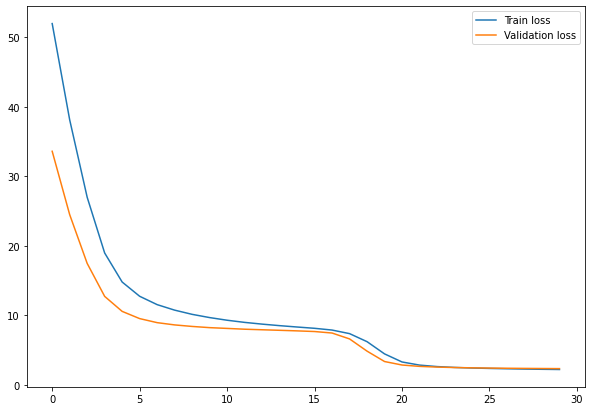

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot(train_loss, label='Train loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend()
plt.show()

In [70]:
get_per(data_loader_val_letters, cpc_model, character_classifier)

N/A% (0 of 48) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (48 of 48) |########################| Elapsed Time: 0:02:25 Time:  0:02:25


Average PER 0.9390852335675514


0.9390852335675514

In [71]:
get_per(data_loader_test_letters, cpc_model, character_classifier)

N/A% (0 of 176) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (176 of 176) |######################| Elapsed Time: 0:08:15 Time:  0:08:15


Average PER 0.9211196840614456


0.9211196840614456